In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


import numpy as np
import matplotlib.pyplot as plt
import copy
from ast import Param
import json

from utils.prune import prune_weights
from utils.count_improvement import improvements
from utils.normalize import normalize_weights

In [2]:
# Verificar si la GPU está disponible y establecer el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Definimos las redes

In [4]:
net = Net().to(device)
varianzas_net = Net().to(device)

Cargamos los datos

In [5]:
# Definimos el transform para los datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargamos el dataset de MNIST
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Definimos los DataLoaders para los conjuntos de entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [6]:
# Definimos la función de pérdida para calcular el error
criterion = nn.CrossEntropyLoss()

In [7]:
# train loop
train_loss = []
test_accuracies = []
epoch = 1
accuracy_threshold = 0.4
best_loss = 100000 # Inicializamos con un valor muy alto para que el primer valor sea mas bajo

#normalizamos varianzas
for layer in varianzas_net.modules():
    if isinstance(layer, nn.Linear):
        normalize_weights(layer, lower_bound=0.9, upper_bound=1.0)

while True:
    print(f"Epoch {epoch}")
    if epoch <= 9:

        for layer in net.modules():
            if isinstance(layer, nn.Linear):
                normalize_weights(layer, lower_bound=0.01, upper_bound=1.0)

        state_dict_red1 = net.state_dict()
        state_dict_red2 = varianzas_net.state_dict()

        # Crear un nuevo diccionario de estado donde sumamos los pesos
        state_dict_suma = {}
        for key in state_dict_red1:
            if state_dict_red1[key].size() == state_dict_red2[key].size():  # Asegurar que las dimensiones coincidan
                # Asegurar que las desviaciones estándar sean positivas para generar el ruido
                std_dev = torch.abs(state_dict_red2[key])
                
                # Generamos los valores aleatorios con una distribución normal usando torch.normal
                noise = torch.normal(0, std_dev)
                
                # Aplicar la operación de suma
                state_dict_suma[key] = state_dict_red1[key] + noise
            else:
                # Si los tamaños no coinciden, copiamos directamente
                state_dict_suma[key] = state_dict_red1[key]

        # Crear una nueva red o modificar una existente con los pesos sumados
        varied_net = Net().to(device)
        varied_net.load_state_dict(state_dict_suma)

        pruned_net = prune_weights(varied_net)

        running_loss = 0.0
        # Pasamos todas las imagenes de train por la red net
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs_net = pruned_net(images)
            loss = criterion(outputs_net, labels)

            running_loss += loss.item()

        if running_loss < best_loss: # Guardamos los pesos de la red con menor pérdida
            best_loss = running_loss
            net.load_state_dict(state_dict_suma)

        train_loss.append(running_loss / len(train_loader))
        print(f"Train loss: {running_loss / len(train_loader)}")

        # Evaluamos el modelo en el conjunto de test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs_net = pruned_net(images)
                _, predicted = torch.max(outputs_net.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracies.append(correct / total)
        print(f"Test accuracy: {correct / total}")

        if correct / total > accuracy_threshold:
            break

    else:
        if epoch == 80: #Verificar pesos y varianzas
            state_dict_suma_serializable = {key: value.cpu().numpy().tolist() for key, value in state_dict_suma.items()}
            state_dict_var_serializable = {key: value.cpu().numpy().tolist() for key, value in state_dict_red2.items()}
            with open("pesos_epoca_80.txt", "w") as f:
                json.dump(state_dict_suma_serializable, f)
            with open("varianzas_epoca_80.txt", "w") as f:
                json.dump(state_dict_var_serializable, f)

        for layer in net.modules():
            if isinstance(layer, nn.Linear):
                normalize_weights(layer, lower_bound=0.01, upper_bound=1.0)

        # Sumamos los pesos de las redes en una red nueva
        state_dict_red1 = net.state_dict()
        state_dict_red2 = varianzas_net.state_dict()

        state_dict_suma = {}
        for key in state_dict_red1:
            if state_dict_red1[key].size() == state_dict_red2[key].size():  # Asegurar que las dimensiones coincidan
                # Asegurar que las desviaciones estándar sean positivas para generar el ruido
                std_dev = torch.abs(state_dict_red2[key])
                
                # Generamos los valores aleatorios con una distribución normal usando torch.normal
                noise = torch.normal(0, std_dev)
                
                # Aplicar la operación de suma
                state_dict_suma[key] = state_dict_red1[key] + noise
            else:
                # Si los tamaños no coinciden, copiamos directamente
                state_dict_suma[key] = state_dict_red1[key]

        # Crear una nueva red o modificar una existente con los pesos sumados
        varied_net = Net().to(device)
        varied_net.load_state_dict(state_dict_suma)

        pruned_net = prune_weights(varied_net)

        running_loss = 0.0
        # Pasamos todas las imagenes de train por la red net
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs_net = pruned_net(images)
            loss = criterion(outputs_net, labels)

            running_loss += loss.item()
        
        if running_loss < best_loss: # Guardamos los pesos de la red con menor pérdida
            best_loss = running_loss
            net.load_state_dict(state_dict_suma)

        train_loss.append(running_loss / len(train_loader))
        print(f"Train loss: {running_loss / len(train_loader)}")

        # Evaluamos el modelo en el conjunto de test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs_net = pruned_net(images)
                _, predicted = torch.max(outputs_net.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracies.append(correct / total)
        print(f"Test accuracy: {correct / total}")

        if correct / total > accuracy_threshold:
            break

        # actualizmos el vector de varianzas
        if improvements(train_loss) > 2:## +mejoras que peoras
            with torch.no_grad():
                for param in varianzas_net.parameters():
                    param *= (1/0.82)

        elif improvements(train_loss) < 2: ## -mejoras que peoras
            with torch.no_grad():
                for param in varianzas_net.parameters():
                    param *= 0.82
        
        else:
            pass

        #normalizamos varianzas
        for layer in varianzas_net.modules():
            if isinstance(layer, nn.Linear):
                normalize_weights(layer, lower_bound=0.9, upper_bound=1.0)
    
    epoch += 1

Epoch 1
Train loss: 24037.464545992138
Test accuracy: 0.0517
Epoch 2
Train loss: 18280.07958151486
Test accuracy: 0.1093
Epoch 3
Train loss: 28953.55067817997
Test accuracy: 0.0642
Epoch 4
Train loss: 39719.435421941635
Test accuracy: 0.0978
Epoch 5
Train loss: 58255.75778959555
Test accuracy: 0.1053
Epoch 6
Train loss: 20019.418625691298
Test accuracy: 0.0668
Epoch 7
Train loss: 41940.413560684305
Test accuracy: 0.1032
Epoch 8
Train loss: 27951.333587711553
Test accuracy: 0.0588
Epoch 9
Train loss: 31411.588358084024
Test accuracy: 0.1133
Epoch 10
Train loss: 34571.28201417577
Test accuracy: 0.1168
Epoch 11
Train loss: 42807.579320195895
Test accuracy: 0.1049
Epoch 12
Train loss: 14523.49575330657
Test accuracy: 0.0645
Epoch 13
Train loss: 27517.684380830226
Test accuracy: 0.1307
Epoch 14
Train loss: 25940.416462261794
Test accuracy: 0.1312
Epoch 15
Train loss: 34060.7209863073
Test accuracy: 0.107
Epoch 16
Train loss: 18674.867609670677
Test accuracy: 0.1238
Epoch 17
Train loss: 4191

KeyboardInterrupt: 

In [8]:
print(max(test_accuracies))

0.1752


In [9]:
print(train_loss)

[24037.464545992138, 18280.07958151486, 28953.55067817997, 39719.435421941635, 58255.75778959555, 20019.418625691298, 41940.413560684305, 27951.333587711553, 31411.588358084024, 34571.28201417577, 42807.579320195895, 14523.49575330657, 27517.684380830226, 25940.416462261794, 34060.7209863073, 18674.867609670677, 41911.74436550507, 30261.113035547707, 26347.32094757796, 19927.052130530385, 29146.281395755595, 41229.11083880264, 33552.812032540976, 37879.42445695629, 26773.130523096017, 28042.042691814364, 26186.242777810166, 21716.306842600614, 24249.663122376398, 24634.921848972215, 21237.290262901453, 15230.408408223948, 68120.47771813367, 40300.99470074294, 48370.096007129534, 33288.41832376899, 24729.27545621502, 54291.69217667244, 25085.936281899652, 32528.781747651254, 36981.33498071862, 12849.247814707156, 34212.957241554504, 16487.430713515292, 35727.427148229275, 18674.62797237307, 19261.85552080557, 26635.888770780584, 21634.76869523754, 62408.261885327825, 30184.27058901919, 

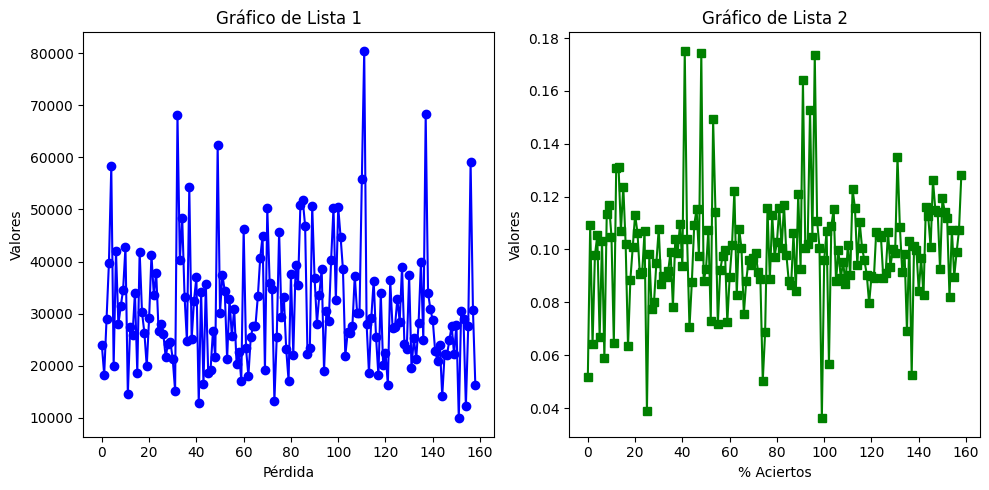

In [10]:
# Creamos la figura y definimos dos subgráficos (1 fila, 2 columnas)
plt.figure(figsize=(10, 5))

# Primer gráfico en la posición 1 (izquierda)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(train_loss, color='blue', marker='o')
plt.title("Gráfico de Pérdida")
plt.xlabel("Pérdida")
plt.ylabel("Valores")

# Segundo gráfico en la posición 2 (derecha)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(test_accuracies, color='green', marker='s')
plt.title("Gráfico de aciertos")
plt.xlabel("% Aciertos")
plt.ylabel("Valores")

# Mostramos los gráficos
plt.tight_layout()  # Ajustamos para que no se solapen los gráficos
plt.show()